## 9. Tuning Hyperparameters Under 10 Minutes (LGBM)

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2021.10.18 </div>
<div style="text-align: right\"> Last update: 2021.10.18</div>

- 출처 : https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm

In [8]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

산탄데르 데이터셋을 사용한다.

In [2]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=ed44756252ecd8d869cc76c70f6f44c75fc40473506662a46c863e0dba97c404
  Stored in directory: c:\users\km.yu99\appdata\local\pip\cache\wheels\37\fa\19\f93e793d3944567a60b3ab93b446cf7370cc82c60c1d1c613f
Successfully built bayesian-optimization


In [3]:
!pip install scikit-optimize

In [4]:
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

In [9]:
#building models
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

In [11]:
!pip install shap

In [12]:
#metrics 
from sklearn.metrics import roc_auc_score, roc_curve
import shap

In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### 데이터 읽기

In [16]:
%%time
train= reduce_mem_usage(pd.read_csv("data/santander/train.csv"))
test= reduce_mem_usage(pd.read_csv("data/santander/test.csv"))
print("Shape of train set: ",train.shape)
print("Shape of test set: ",test.shape)

Mem. usage decreased to 78.01 Mb (74.7% reduction)
Mem. usage decreased to 77.82 Mb (74.6% reduction)
Shape of train set:  (200000, 202)
Shape of test set:  (200000, 201)
Wall time: 27 s


In [18]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,...,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,...,7.640625,7.722656,2.583984,10.953125,15.429688,2.033203,8.125000,8.789062,18.359375,1.952148
2,train_2,0,8.609375,-2.746094,12.078125,7.894531,10.585938,-9.085938,6.941406,14.617188,...,2.906250,9.789062,1.669922,1.685547,21.609375,3.142578,-6.519531,8.265625,14.718750,0.396484
3,train_3,0,11.062500,-2.152344,8.953125,7.195312,12.585938,-1.835938,5.843750,14.921875,...,4.464844,4.742188,0.717773,1.421875,23.031250,-1.270508,-2.927734,10.289062,17.968750,-9.000000
4,train_4,0,9.835938,-1.483398,12.875000,6.636719,12.273438,2.449219,5.941406,19.250000,...,-1.490234,9.523438,-0.150757,9.195312,13.289062,-1.511719,3.925781,9.500000,18.000000,-8.812500


In [19]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

### Bayesian Optimization with LightGBM

In [20]:
y=train['target']
X=train.drop(['ID_code','target'],axis=1)

In [21]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

In [22]:
opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Info] Number of positive: 13399, number of negative: 119934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Info] Number of positive: 13398, number of negative: 119935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5388
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.819

[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Info] Number of positive: 13399, number of negative: 119935
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2000
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100493 -> initscore=-2.191762
[LightGBM] [Info] Start training from score -2.191762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100485 -> initscore=-2.191844
[LightGBM] [Info] Start training fro

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 13399, number of negative: 119934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5985
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0,

[LightGBM] [Info] Start training from score -2.191770
|  10       |  0.87     |  1.0      |  0.9      |  0.1719   |  81.38    |  26.17    |  55.8     |  46.83    |  24.0     |  1.0      |
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 13399, number of negative: 119934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045055 seconds.
You can set `force_col_wise=true` to remove the 

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 13399, number of negative: 119935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3398
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100493 -> initscore=-2.191762
[LightGBM] [Info] Start training from score -2.191762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100485 -> initscore=-2.191844
[LightGBM] [Info] Start training from score -2.191844
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100492 -> initscore=-2.191770
[LightGBM] [Info] Start training from score -2.19177

[LightGBM] [Info] Start training from score -2.191770
|  15       |  0.8442   |  0.9184   |  0.5808   |  0.7906   |  74.01    |  27.36    |  45.6     |  37.98    |  31.09    |  0.5306   |


In [23]:
opt_params

(0.869950989798792,
 {'bagging_fraction': 1.0,
  'feature_fraction': 0.9,
  'learning_rate': 0.1718549530829431,
  'max_bin': 81.37983603860036,
  'max_depth': 26.16709557494532,
  'min_data_in_leaf': 55.797187511967564,
  'min_sum_hessian_in_leaf': 46.82805655404337,
  'num_leaves': 24.0,
  'subsample': 1.0})

In [24]:
opt_params[1]

{'bagging_fraction': 1.0,
 'feature_fraction': 0.9,
 'learning_rate': 0.1718549530829431,
 'max_bin': 81.37983603860036,
 'max_depth': 26.16709557494532,
 'min_data_in_leaf': 55.797187511967564,
 'min_sum_hessian_in_leaf': 46.82805655404337,
 'num_leaves': 24.0,
 'subsample': 1.0}

파라미터를 추가하여 최적의 파라미터를 만든다

In [25]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 1.0,
 'feature_fraction': 0.9,
 'learning_rate': 0.1718549530829431,
 'max_bin': 81,
 'max_depth': 26,
 'min_data_in_leaf': 56,
 'min_sum_hessian_in_leaf': 46.82805655404337,
 'num_leaves': 24,
 'subsample': 1.0,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

### Training LightGBM

In [26]:
target=train['target']
features= [c for c in train.columns if c not in ['target','ID_code']]

In [27]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31416)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

In [28]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(opt_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, 
                    early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

Fold 0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16134
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.988497	valid_1's auc: 0.883424
Early stopping, best iteration is:
[268]	training's auc: 0.967482	valid_1's auc: 0.88736
Fold 1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16134
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.988362	valid_1's auc: 0.885062
Early stopping, best iteration is:
[358]	training's auc: 0.977853	valid_1's auc: 0.886413


In [29]:
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

CV score: 0.88637 


In [30]:
feature_importance_df

,Feature,importance,fold
0,var_0,39,1
1,var_1,58,1
2,var_2,48,1
3,var_3,15,1
4,var_4,17,1
...,...,...,...
195,var_195,48,10
196,var_196,41,10
197,var_197,56,10
198,var_198,65,10


In [31]:
feature_importance_df[["Feature", "importance"]].groupby("Feature").mean()

,importance
Feature,
var_0,42.3
var_1,52.1
var_10,4.7
var_100,7.4
var_101,12.5
...,...
var_95,38.9
var_96,5.8
var_97,24.0


In [32]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)

In [33]:
cols

Index(['var_174', 'var_6', 'var_34', 'var_33', 'var_53', 'var_166', 'var_21',
       'var_22', 'var_78', 'var_76', 'var_110', 'var_165', 'var_1', 'var_190',
       'var_13', 'var_99', 'var_26', 'var_12', 'var_146', 'var_170'],
      dtype='object', name='Feature')

In [34]:
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

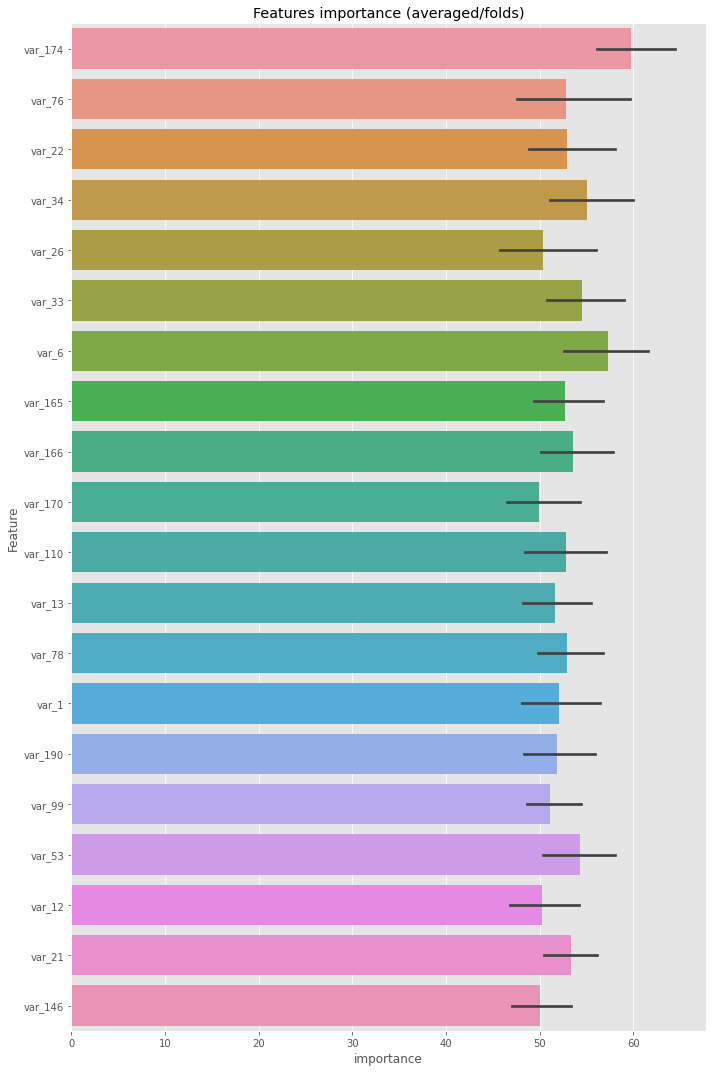

In [36]:
plt.figure(figsize=(10,15))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('Feature_Importance.png')

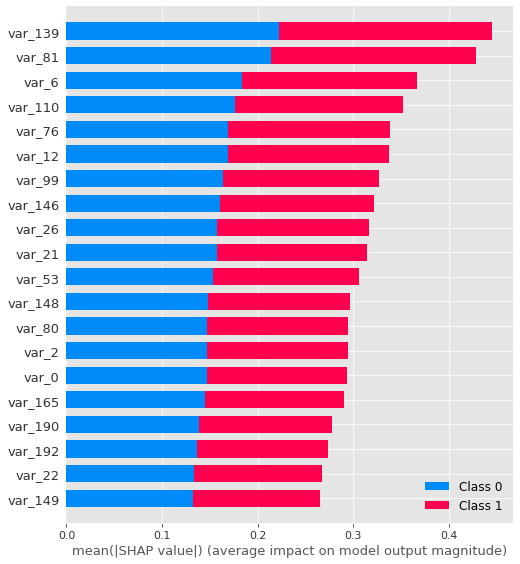

In [37]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)